In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import torch
import cvxpylayers
from cvxpylayers.torch import CvxpyLayer
from tqdm import trange, tqdm
from time import sleep
from algorithms import fit
from utils import latexify

torch.set_default_dtype(torch.float32)
torch.manual_seed(1)
latexify()

/Users/avajiang/opt/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [2]:
# if torch.cuda.is_available():  
#     print('cuda available')
#     dev = "cuda:0" 
# else:  
#     dev = "cpu"  
# device = torch.device(dev)

https://github.com/cvxgrp/cvxpylayers/blob/master/examples/torch/monotonic_output_regression.ipynb

# helper functions

In [3]:
def plot_results(val_losses, train_losses, param_updates, obj_vals, sqrtalpha_true, beta_true, P_untrained, P_trained, P_true, dist):
    epochs = len(val_losses)

    # loss by epoch
    plt.figure(figsize=(6,4))
    plt.plot(val_losses, 'k', label='val')
    plt.plot([np.mean(tl) for tl in train_losses], 'k--', label='train')
    plt.xlabel('epoch')
    plt.ylabel('log(loss)')
    plt.title('Validation and training loss by epoch')
    plt.yscale('log')
    plt.legend()
#     plt.show()
    plt.savefig('figures/grid/loss_%s.jpg'%dist)

    # alpha updates by epoch
    plt.figure(figsize=(6,4))
    plt.plot(param_updates[:,0].detach().numpy(), 'k', label='$\sqrt{\\alpha}$')
    plt.hlines(sqrtalpha_true, 0, epochs, colors='k', linestyles='dashed', label='$\sqrt{\\alpha}$ true')
    plt.xlabel('epoch')
    plt.ylabel('$\sqrt{\\alpha}$')
    plt.title('$\sqrt{\\alpha}$ updates by epoch')
    plt.legend()
#     plt.show()
    plt.savefig('figures/grid/sqrtalpha_%s.jpg'%dist)

    # generator objective value by epoch
    plt.figure(figsize=(6,4))
    plt.plot(obj_vals, 'k', label='train')
    plt.hlines(f_gen(P_true[0,:,0], alpha_true, beta_true).value, 0, epochs-1, colors='k', linestyles='dashed', label='true')
    plt.title('Objective value by epoch')
    plt.xlabel('epoch')
    plt.ylabel('objective value')
    plt.legend()
#     plt.show()
    plt.savefig('figures/grid/objval_%s.jpg'%dist)

    # generator over time
    plt.figure(figsize=(6,4))
    plt.plot(P_untrained[:,0].detach().numpy(), linestyle='dotted', label='untrained')
    plt.plot(P_trained[:,0].detach().numpy(), label='trained')
    plt.plot(P_true[0,:,0], '--', label='true')
    plt.title('Generator over time')
    plt.xlabel('$t$')
    plt.ylabel('$p^1$')
    plt.legend()
#     plt.show()
    plt.savefig('figures/grid/gen_%s.jpg'%dist)

    # balance over time
    plt.figure(figsize=(6,4))
    plt.plot(np.sum(P_untrained.detach().numpy(), axis=1), linestyle='dotted', label='untrained')
    plt.plot(np.sum(P_trained.detach().numpy(), axis=1), label='trained')
    plt.plot(torch.sum(P_true[0,:,:], axis=1), '--', label='true')
    plt.title('Balance over time')
    plt.xlabel('$t$')
    plt.ylabel('balance')
    plt.legend()
#     plt.show()
    plt.savefig('figures/grid/balance_%s.jpg'%dist)

# setup

In [4]:
T = 50
M = 3
pmin, pmax = 0.01, 50
Q, C, D = 50, 10, 10

In [5]:
# generator that can't be powered off (for simplicity and convexity)
def f_gen(p_gen,sqrt_alpha,beta):
    return cp.sum_squares(sqrt_alpha*p_gen) - beta*cp.sum(p_gen)

def c_gen(p_gen):
    constraints = [-p_gen >= pmin,
                   -p_gen <= pmax
                  ]
    return constraints

In [6]:
# load (fixed)
def f_load(p_load):
    return 0

def c_load(p_load,l):
    constraints = [p_load == l]
    return constraints

In [7]:
# storage device
def f_bat(p_bat):
    return 0

def c_bat(p_bat):
    q = cp.cumsum(p_bat)
    constraints = [p_bat >= -D,
                   p_bat <= C,
                   q >= 0,
                   q <= Q,
                  ]
    return constraints

# method 1: non-distributed

In [8]:
# set up variables and parameters
sqrt_alpha = cp.Parameter()
beta = cp.Parameter()
l = cp.Parameter(T)
p = cp.Variable((T,M))
    
# set up objective
objective = f_gen(p[:,0],sqrt_alpha,beta)
constraints = [c for c in c_gen(p[:,0])] + [c for c in c_load(p[:,1],l)] + [c for c in c_bat(p[:,2])] + [cp.sum(p,axis=1)==0]
prob = cp.Problem(cp.Minimize(objective),constraints)

# convert into pytorch layer
layer = CvxpyLayer(prob, [sqrt_alpha,beta,l], [p])

## forward pass

In [9]:
# get data
def get_data_nd(N, T, sqrtalpha, beta):
    L = torch.randint(3,11,size=(N,T))
    L = L.float()
    sqrtalpha = sqrtalpha.repeat(N)
    beta = beta.repeat(N)
    P = layer(sqrtalpha,beta,L,solver_args={"solve_method":'ECOS'})[0]

    return L,P

alphamin = 0.1
alphamax = 0.2
alpha_true = (alphamax-alphamin)*torch.rand(1) + alphamin
sqrtalpha_true = torch.sqrt(alpha_true)
print('sqrtalpha_true: ', sqrtalpha_true)

betamin = 0.5
betamax = 1.5
beta_true = (betamax-betamin)*torch.rand(1) + betamin
print('beta_true: ', beta_true)

L, P_nd = get_data_nd(100, T, sqrtalpha_true, beta_true)
Lval, Pval_nd = get_data_nd(50, T, sqrtalpha_true, beta_true)

sqrtalpha_true:  tensor([0.4192])
beta_true:  tensor([0.7793])


## backward pass

In [10]:
# mse_loss = torch.nn.MSELoss()
l1_loss = torch.nn.L1Loss()
torch.manual_seed(0)
sqrtalpha = 3*torch.rand(1)
print(sqrtalpha)
beta = beta_true
sqrtalpha.requires_grad_(True)

def loss_nd(L,P,sqrtalpha,beta):
    N = L.shape[0]
    sqrtalpha_batch = sqrtalpha.repeat(N)
    beta_batch = beta.repeat(N)
    return l1_loss(layer(sqrtalpha_batch, beta_batch, L)[0],P)

tensor([1.4888])


In [11]:
epochs = 30
val_losses_nd, train_losses_nd, param_updates_nd = fit(lambda L,P: loss_nd(L,P,sqrtalpha,beta), [sqrtalpha], L, P_nd, Lval, Pval_nd,
                                                       opt=torch.optim.Adam, opt_kwargs={"lr": 5e-2},
                                                       batch_size=20, epochs=epochs, verbose=True)

/Users/avajiang/opt/anaconda3/lib/python3.8/site-packages/diffcp/cone_program.py:282: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")


001 | 0.57109
batch 001 / 005 | 0.58353
batch 002 / 005 | 0.57726
batch 003 / 005 | 0.57306
batch 004 / 005 | 0.57101
batch 005 / 005 | 0.56759
002 | 0.51616
batch 001 / 005 | 0.53544
batch 002 / 005 | 0.48000
batch 003 / 005 | 0.39083
batch 004 / 005 | 0.33503
batch 005 / 005 | 0.28258
003 | 0.03731
batch 001 / 005 | 0.03740
batch 002 / 005 | 0.03198
batch 003 / 005 | 0.02792
batch 004 / 005 | 0.02534
batch 005 / 005 | 0.02369
004 | 0.01052
batch 001 / 005 | 0.01186
batch 002 / 005 | 0.01154
batch 003 / 005 | 0.01136
batch 004 / 005 | 0.01011
batch 005 / 005 | 0.00921
005 | 0.00496
batch 001 / 005 | 0.00676
batch 002 / 005 | 0.00561
batch 003 / 005 | 0.00496
batch 004 / 005 | 0.00458
batch 005 / 005 | 0.00436
006 | 0.00235
batch 001 / 005 | 0.00267
batch 002 / 005 | 0.00260
batch 003 / 005 | 0.00256
batch 004 / 005 | 0.00227
batch 005 / 005 | 0.00215
007 | 0.00108
batch 001 / 005 | 0.00138
batch 002 / 005 | 0.00161
batch 003 / 005 | 0.00132
batch 004 / 005 | 0.00117
batch 005 / 005 | 

In [12]:
obj_vals_nd = np.zeros(epochs)
for epoch in range(epochs):
    N = Lval.shape[0]
    sqrtalpha_temp = param_updates_nd[epoch,0]
    P_gen_temp = layer(sqrtalpha_temp, beta_true, Lval[0,:], solver_args={"solve_method":'ECOS'})[0][0,:,0]
    obj_vals_nd[epoch] = f_gen(P_gen_temp.detach().numpy(), sqrtalpha_temp.detach().numpy(), beta_true).value
    
P_untrained_nd = layer(param_updates_nd[0,0], beta_true, Lval[0,:], solver_args={"solve_method":'ECOS'})[0][0,:,:]
P_trained_nd = layer(param_updates_nd[-1,0], beta_true, Lval[0,:], solver_args={"solve_method":'ECOS'})[0][0,:,:]

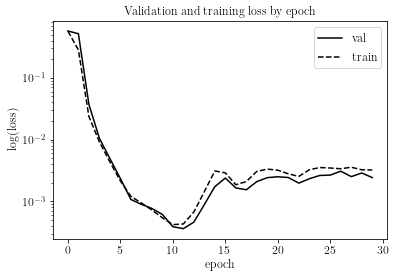

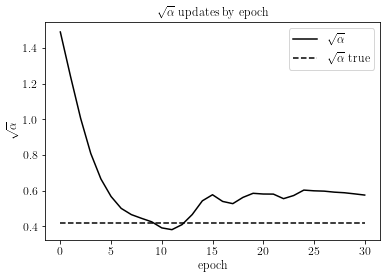

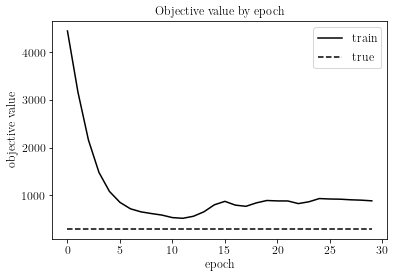

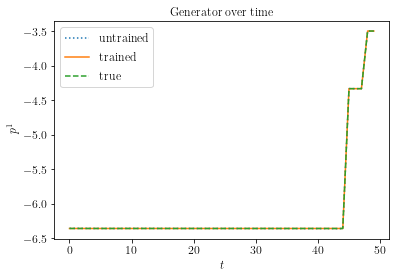

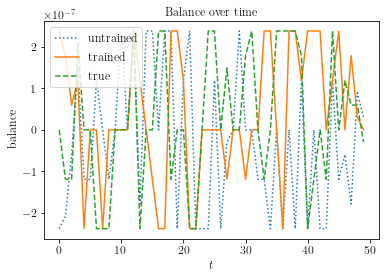

In [13]:
plot_results(val_losses_nd, train_losses_nd, param_updates_nd, obj_vals_nd, sqrtalpha_true, beta_true, P_untrained_nd, P_trained_nd, Pval_nd, 'nd')

# method 2: distributed

In [14]:
QUIET    = 1
MAX_ITER = 80
rho = 1

In [15]:
# set up problem
pvar = [cp.Variable(T)]*2
d = cp.Parameter(T)
v = cp.Parameter(T)
sqrt_alpha = cp.Parameter()
beta = cp.Parameter()
obj = [f_gen(pvar[0],sqrt_alpha,beta) + rho/2*cp.sum_squares(v - pvar[0]),
       rho/2*cp.sum_squares(v - pvar[1])]
prox = [cp.Problem(cp.Minimize(obj[0]), c_gen(pvar[0])),
        cp.Problem(cp.Minimize(obj[1]), c_bat(pvar[1]))]
layers = [CvxpyLayer(prox[0],[v,sqrt_alpha,beta],[pvar[0]]),
          CvxpyLayer(prox[1],[v],[pvar[1]])]

In [16]:
def admm(L,sqrtalpha,beta,layers):
    N,T = L.shape
    
    P = torch.zeros((N,T,M))
    P[:,:,1] = L
    u = torch.zeros((N,T,M))
    r_norm = torch.zeros((N,MAX_ITER))
    s_norm = torch.zeros((N,MAX_ITER))

    for k in tqdm(range(MAX_ITER)):
        P_old = P
        Pbar_old = torch.mean(P_old,axis=2,keepdim=True)
        
        # p-update
        try:
            P[:,:,0] = layers[0](P[:,:,0] - torch.mean(P,axis=2) - u[:,:,0],sqrtalpha,beta,solver_args={'eps':1e-6, 'acceleration_lookback': 20})[0] # generator
        except:
            break
        try:
            P[:,:,2] = layers[1](P[:,:,2] - torch.mean(P,axis=2) - u[:,:,2],solver_args={'eps':1e-6, 'acceleration_lookback': 20})[0]                # battery 
        except:
            break
        
        Pbar = torch.mean(P,axis=2,keepdim=True)

        # u-update
        u += Pbar
        
        # progress tracking
        r_norm[:,k] = torch.flatten(torch.linalg.norm(Pbar,dim=1))
        s_norm[:,k] = torch.flatten(torch.linalg.norm(torch.reshape((P - Pbar) - (P_old - Pbar_old),(N,T*M)),dim=1))
        
    return P,r_norm,s_norm

## forward pass

In [17]:
def get_data_d(L, sqrtalpha, beta):
    N = L.shape[0]
    P,r_norm,s_norm = admm(L, sqrtalpha.repeat(N), beta.repeat(N), layers)

    return P,r_norm,s_norm

P_d, r_norm, s_norm = get_data_d(L, sqrtalpha_true, beta_true)
Pval_d, r_normval, s_normval = get_data_d(Lval, sqrtalpha_true, beta_true)

  0%|          | 0/80 [00:00<?, ?it/s]/Users/avajiang/opt/anaconda3/lib/python3.8/site-packages/diffcp/cone_program.py:282: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")
100%|██████████| 80/80 [03:34<00:00,  2.68s/it]


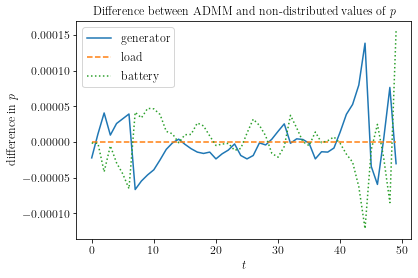

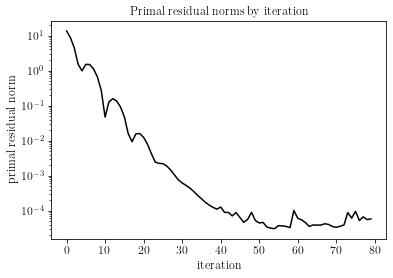

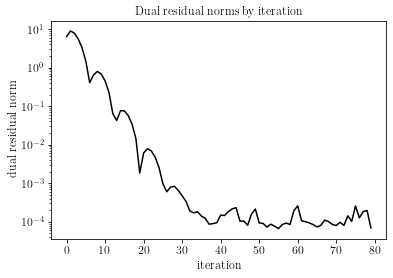

In [20]:
# compare results
# plt.figure(figsize=(6,4))
# plt.plot(Y_d[0,:,2], label = 'admm')
# plt.plot(Y_nd[0,:,2], label = 'non-distributed')
# plt.legend()
# plt.title('Non-distributed vs distributed')
# plt.show()

# compare results for each device
plt.figure(figsize=(6,4))
plt.plot(P_d[0,:,0] - P_nd[0,:,0], label='generator')
plt.plot(P_d[0,:,1] - P_nd[0,:,1], '--', label='load')
plt.plot(P_d[0,:,2] - P_nd[0,:,2], linestyle='dotted', label='battery')
plt.title('Difference between ADMM and non-distributed values of $p$')
plt.xlabel('$t$')
plt.ylabel('difference in $p$')
plt.legend()
# plt.show()
plt.savefig('figures/grid/fp_comp.jpg')

# # compare balance over time
# plt.figure(figsize=(6,4))
# plt.plot(torch.sum(Y_d[0,:,:], axis=1), 'k', label='admm')
# plt.plot(torch.sum(Y_nd[0,:,:], axis=1), label='nd')
# plt.title('Balance over time')
# plt.xlabel('$T$')
# plt.ylabel('balance')
# plt.legend()
# plt.savefig('balance_d.jpg')
# # plt.show()

# primal residual tracking 
plt.figure(figsize=(6,4))
plt.plot(r_norm[0,:], 'k')
plt.yscale('log')
plt.title('Primal residual norms by iteration')
plt.xlabel('iteration')
plt.ylabel('primal residual norm')
plt.savefig('figures/grid/fp_rnorm.jpg')
# plt.show()

# dual residual tracking
plt.figure(figsize=(6,4))
plt.plot(s_norm[0,:], 'k')
plt.yscale('log')
plt.title('Dual residual norms by iteration')
plt.xlabel('iteration')
plt.ylabel('dual residual norm')
plt.savefig('figures/grid/fp_snorm.jpg')
# plt.show()

# backward pass

In [21]:
# mse_loss = torch.nn.MSELoss()
l1_loss = torch.nn.L1Loss()
torch.manual_seed(0)
sqrtalpha = 3*torch.rand(1)
# sqrtalpha = torch.tensor([0.4])
print(sqrtalpha)
beta = beta_true
sqrtalpha.requires_grad_(True)
# beta.requires_grad_(True)

def loss_d(L,P,sqrtalpha,beta):
    N = L.shape[0]
    return l1_loss(admm(L, sqrtalpha.repeat(N), beta.repeat(N), layers)[0],P)

tensor([1.4888])


In [22]:
val_losses_d, train_losses_d ,param_updates_d = fit(lambda L,P: loss_d(L,P,sqrtalpha,beta), [sqrtalpha], L, P_d, Lval, Pval_d,
                                                    opt=torch.optim.Adam, opt_kwargs={"lr": 1e-1},
                                                    batch_size=20, epochs=epochs, verbose=True)

  1%|▏         | 1/80 [00:02<02:58,  2.27s/it]/Users/avajiang/opt/anaconda3/lib/python3.8/site-packages/diffcp/cone_program.py:282: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")
  0%|          | 0/80 [00:00<?, ?it/s]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.
001 | 1.28898


 12%|█▎        | 10/80 [00:12<01:28,  1.27s/it]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.



  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 1.11201


 10%|█         | 8/80 [00:09<01:25,  1.18s/it]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.



  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 1.14554


 15%|█▌        | 12/80 [00:15<01:26,  1.27s/it]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.



  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 1.01967


 19%|█▉        | 15/80 [00:20<01:27,  1.35s/it]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.



  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.97183


 26%|██▋       | 21/80 [00:29<01:22,  1.40s/it]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.



  0%|          | 0/80 [00:00<?, ?it/s]

batch 005 / 005 | 0.82026


  0%|          | 0/80 [00:00<?, ?it/s]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.
002 | 0.10232


 34%|███▍      | 27/80 [00:33<01:06,  1.25s/it]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.



  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 0.03431


 35%|███▌      | 28/80 [00:36<01:07,  1.31s/it]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.



  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 0.03205


 30%|███       | 24/80 [00:30<01:10,  1.26s/it]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.



  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 0.02680


  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.02025


  0%|          | 0/80 [00:00<?, ?it/s]

batch 005 / 005 | 0.01621


  0%|          | 0/80 [00:00<?, ?it/s]

003 | 0.00002


  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 0.00001


  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 0.00002


  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 0.00002


  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.00001


  0%|          | 0/80 [00:00<?, ?it/s]

batch 005 / 005 | 0.00001


  0%|          | 0/80 [00:00<?, ?it/s]

004 | 0.00001


  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 0.00001


  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 0.00001


  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 0.00001


  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.00002


  0%|          | 0/80 [00:00<?, ?it/s]

batch 005 / 005 | 0.00003


  0%|          | 0/80 [00:00<?, ?it/s]

005 | 0.00033


  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 0.00033


  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 0.00070


  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 0.00139


  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.00257


  0%|          | 0/80 [00:00<?, ?it/s]

batch 005 / 005 | 0.00392


  0%|          | 0/80 [00:00<?, ?it/s]

006 | 0.01254


  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 0.01059


  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 0.00984


  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 0.00832


  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.00689


  0%|          | 0/80 [00:00<?, ?it/s]

batch 005 / 005 | 0.00576


  0%|          | 0/80 [00:00<?, ?it/s]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.
007 | 0.00938


  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 0.00062


  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 0.00048


  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 0.00039


  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.00033


  0%|          | 0/80 [00:00<?, ?it/s]

batch 005 / 005 | 0.00029


  0%|          | 0/80 [00:00<?, ?it/s]

008 | 0.00018


  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 0.00019


  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 0.00023


  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 0.00028


  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.00038


  0%|          | 0/80 [00:00<?, ?it/s]

batch 005 / 005 | 0.00051


  0%|          | 0/80 [00:00<?, ?it/s]

009 | 0.00158


  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 0.00160


  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 0.00202


  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 0.00238


  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.00262


  0%|          | 0/80 [00:00<?, ?it/s]

batch 005 / 005 | 0.00278


  0%|          | 0/80 [00:00<?, ?it/s]

010 | 0.00319


  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 0.00325


  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 0.00293


  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 0.00262


  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.00231


  0%|          | 0/80 [00:00<?, ?it/s]

batch 005 / 005 | 0.00207


  0%|          | 0/80 [00:00<?, ?it/s]

011 | 0.00086


  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 0.00086


  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 0.00080


  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 0.00076


  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.00075


  0%|          | 0/80 [00:00<?, ?it/s]

batch 005 / 005 | 0.00078


  0%|          | 0/80 [00:00<?, ?it/s]

012 | 0.00093


  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 0.00096


  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 0.00105


  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 0.00108


  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.00116


  0%|          | 0/80 [00:00<?, ?it/s]

batch 005 / 005 | 0.00125


  0%|          | 0/80 [00:00<?, ?it/s]

013 | 0.00170


  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 0.00174


  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 0.00173


  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 0.00173


  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.00168


  0%|          | 0/80 [00:00<?, ?it/s]

batch 005 / 005 | 0.00165


  0%|          | 0/80 [00:00<?, ?it/s]

014 | 0.00144


  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 0.00153


  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 0.00144


  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 0.00137


  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.00133


  0%|          | 0/80 [00:00<?, ?it/s]

batch 005 / 005 | 0.00131
new lr: 0.05


  0%|          | 0/80 [00:00<?, ?it/s]

015 | 0.00122


  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 0.00124


  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 0.00656


  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 0.00532


  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.00416


  0%|          | 0/80 [00:00<?, ?it/s]

batch 005 / 005 | 0.00337


  0%|          | 0/80 [00:00<?, ?it/s]

016 | 0.00013


  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 0.00013


  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 0.00013


  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 0.00014


  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.00016


  0%|          | 0/80 [00:00<?, ?it/s]

batch 005 / 005 | 0.00022


  0%|          | 0/80 [00:00<?, ?it/s]

017 | 0.00109


  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 0.00109


  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 0.00175


  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 0.00275


  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.00359


  0%|          | 0/80 [00:00<?, ?it/s]

batch 005 / 005 | 0.00373


  0%|          | 0/80 [00:00<?, ?it/s]

018 | 0.00230


  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 0.00239


  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 0.00177


  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 0.00138


  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.00115


  0%|          | 0/80 [00:00<?, ?it/s]

batch 005 / 005 | 0.00099


  0%|          | 0/80 [00:00<?, ?it/s]

019 | 0.00033


  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 0.00033


  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 0.00039


  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 0.00046


  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.00053


  0%|          | 0/80 [00:00<?, ?it/s]

batch 005 / 005 | 0.00067


  0%|          | 0/80 [00:00<?, ?it/s]

020 | 0.00187


  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 0.00190


  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 0.00221


  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 0.00239


  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.00244


  0%|          | 0/80 [00:00<?, ?it/s]

batch 005 / 005 | 0.00242


  0%|          | 0/80 [00:00<?, ?it/s]

021 | 0.00248


  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 0.00201


  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 0.00186


  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 0.00171


  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.00159


  0%|          | 0/80 [00:00<?, ?it/s]

batch 005 / 005 | 0.00147


  0%|          | 0/80 [00:00<?, ?it/s]

022 | 0.00075


  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 0.00076


  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 0.00073


  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 0.00072


  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.00076


  0%|          | 0/80 [00:00<?, ?it/s]

batch 005 / 005 | 0.00084


  0%|          | 0/80 [00:00<?, ?it/s]

023 | 0.00139


  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 0.00143


  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 0.00152


  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 0.00154


  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.00152


  0%|          | 0/80 [00:00<?, ?it/s]

batch 005 / 005 | 0.00153


  0%|          | 0/80 [00:00<?, ?it/s]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.
024 | 0.62561


  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 0.00171


  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 0.00170


  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 0.00170


  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.00168


  0%|          | 0/80 [00:00<?, ?it/s]

batch 005 / 005 | 0.00166


  0%|          | 0/80 [00:00<?, ?it/s]

025 | 0.00144


  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 0.00143


  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 0.00144


  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 0.00139


  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.00134


  0%|          | 0/80 [00:00<?, ?it/s]

batch 005 / 005 | 0.00129


  0%|          | 0/80 [00:00<?, ?it/s]

026 | 0.00114


  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 0.00116


  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 0.00116


  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 0.00123


  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.00134


  0%|          | 0/80 [00:00<?, ?it/s]

batch 005 / 005 | 0.00138


  0%|          | 0/80 [00:00<?, ?it/s]

027 | 0.00141


  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 0.00136


  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 0.00134


  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 0.00125


  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.00117


  0%|          | 0/80 [00:00<?, ?it/s]

batch 005 / 005 | 0.00117


  0%|          | 0/80 [00:00<?, ?it/s]

028 | 0.00126


  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 0.00128


  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 0.00149


  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 0.00159


  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.00164


  0%|          | 0/80 [00:00<?, ?it/s]

batch 005 / 005 | 0.00168


  0%|          | 0/80 [00:00<?, ?it/s]

029 | 0.00156


  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 0.00157


  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 0.00152


  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 0.00138


  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.00127


  0%|          | 0/80 [00:00<?, ?it/s]

batch 005 / 005 | 0.00122
new lr: 0.025


  0%|          | 0/80 [00:00<?, ?it/s]

030 | 0.00094


  0%|          | 0/80 [00:00<?, ?it/s]

batch 001 / 005 | 0.00097


  0%|          | 0/80 [00:00<?, ?it/s]

batch 002 / 005 | 0.00201


  0%|          | 0/80 [00:00<?, ?it/s]

batch 003 / 005 | 0.00225


  0%|          | 0/80 [00:00<?, ?it/s]

batch 004 / 005 | 0.00204


100%|██████████| 80/80 [01:32<00:00,  1.15s/it]


batch 005 / 005 | 0.00176


In [23]:
N = Lval.shape[0]
obj_vals_d = np.zeros(epochs)
for epoch in range(epochs):
    sqrtalpha_temp = param_updates_d[epoch,0]
    P_gen = admm(Lval, sqrtalpha_temp.repeat(N), beta_true.repeat(N), layers)[0][0,:,0]
    obj_vals_d[epoch] = f_gen(P_gen.detach().numpy(), sqrtalpha_temp.detach().numpy(), beta_true).value

P_untrained_d = layer(param_updates_nd[0,0], beta_true, Lval[0,:], solver_args={"solve_method":'ECOS'})[0][0,:,:]
P_trained_d = admm(Lval, param_updates_d[-1,0].repeat(N), beta_true.repeat(N), layers)[0][0,:,:]

  0%|          | 0/80 [00:00<?, ?it/s]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.


  0%|          | 0/80 [00:00<?, ?it/s]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.


 68%|██████▊   | 54/80 [02:31<01:12,  2.80s/it]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.



  5%|▌         | 4/80 [00:12<03:52,  3.07s/it]

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.



100%|██████████| 80/80 [03:49<00:00,  2.86s/it]


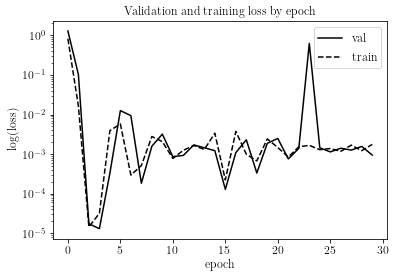

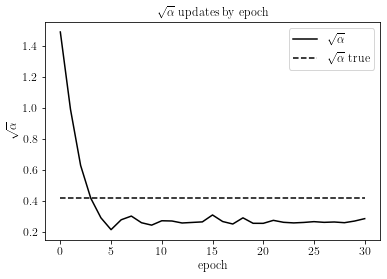

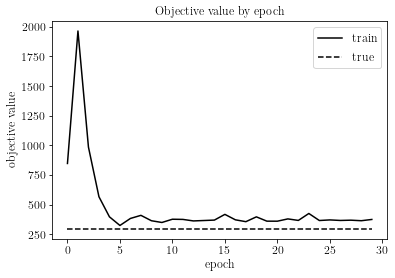

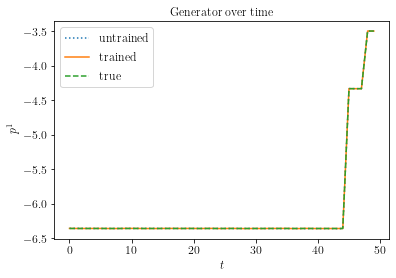

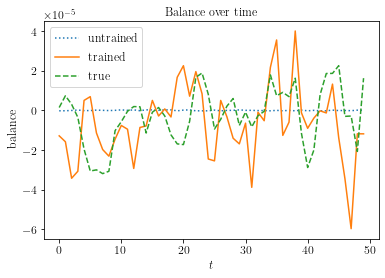

In [24]:
plot_results(val_losses_d, train_losses_d, param_updates_d, obj_vals_d, sqrtalpha_true, beta_true, P_untrained_d, P_trained_d, Pval_d, 'd')